In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
# FDM config.
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

In [10]:
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
x, y = np.meshgrid(X, Y)

In [5]:
# FDM solver
B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
print(f"\ncomputation time: {end-start:.3f}\n")


computation time: 77.828



Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

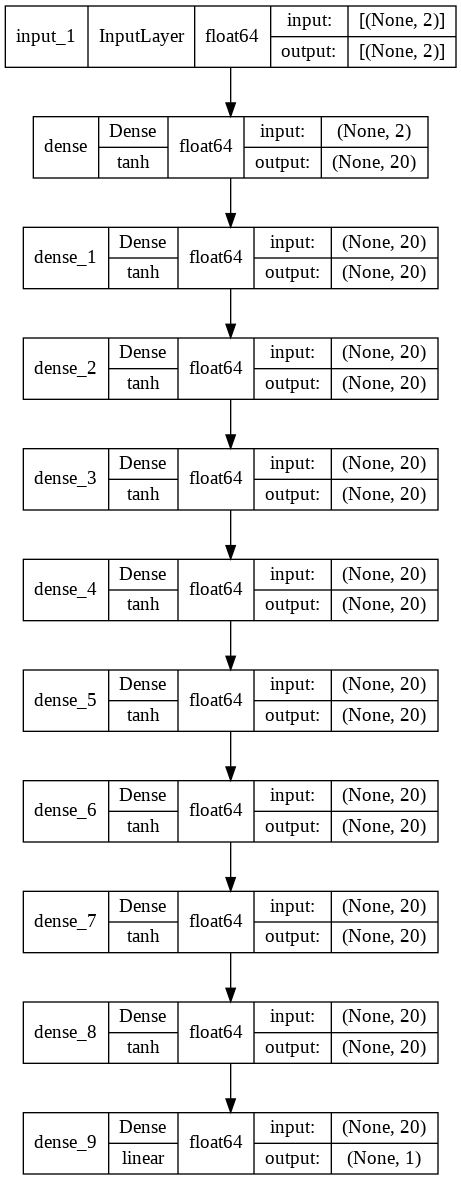

In [6]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

###
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 9, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

In [11]:
x_data, y_data, T_data = np.reshape(x, [n*n, 1]), np.reshape(y, [n*n, 1]), np.reshape(T, [n*n, 1])
data = pd.DataFrame(np.concatenate([x_data, y_data, T_data], axis=1), 
                    columns=["x", "y", "T"])
#
train = data.sample(frac=0.7, replace=False)
data = data.drop(train.index)
test = data.sample(frac=2/3, replace=False)
val = data.drop(test.index)
train, test, val = [*map(np.array, [train, test, val])]

In [12]:
x_train, y_train, T_train = train[:, 0], train[:, 1], train[:, 2]
x_test, y_test, T_test = test[:, 0], test[:, 1], test[:, 2]
x_val, y_val, T_val = val[:, 0], val[:, 1], val[:, 2]

In [13]:
X = train[:, :2]
Y = T_train
#
X_test = test[:, :2]
Y_test = T_test
#
X_val = val[:, :2]
Y_val = T_val

In [16]:
optim = tf.keras.optimizers.Adam(learning_rate=5e-4)

model.compile(optimizer=optim,
              loss="mse")


history = model.fit(X, Y, epochs=1000, 
                    validation_data=(X_val, Y_val))

Epoch 1/1000
219/219 [==============================] - 2s 6ms/step - loss: 336.7784 - val_loss: 282.7106
Epoch 2/1000
219/219 [==============================] - 1s 5ms/step - loss: 288.3673 - val_loss: 240.7120
Epoch 3/1000
219/219 [==============================] - 1s 5ms/step - loss: 246.9149 - val_loss: 205.3727
Epoch 4/1000
219/219 [==============================] - 1s 5ms/step - loss: 212.1083 - val_loss: 176.1751
Epoch 5/1000
219/219 [==============================] - 1s 5ms/step - loss: 181.6400 - val_loss: 150.4458
Epoch 6/1000
219/219 [==============================] - 1s 5ms/step - loss: 155.6728 - val_loss: 128.5446
Epoch 7/1000
219/219 [==============================] - 1s 5ms/step - loss: 133.6940 - val_loss: 109.8882
Epoch 8/1000
219/219 [==============================] - 1s 5ms/step - loss: 114.8814 - val_loss: 93.8958
Epoch 9/1000
219/219 [==============================] - 1s 6ms/step - loss: 98.3203 - val_loss: 80.4598
Epoch 10/1000
219/219 [==========================

In [17]:
model.evaluate(x=X_test, y=Y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.2504


0.2504415568113327

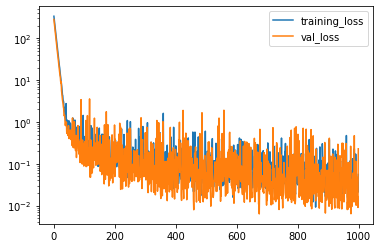

In [19]:
plt.semilogy(history.history["loss"], label="training_loss")
plt.semilogy(history.history["val_loss"], label="val_loss")
plt.legend()